# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
try:
  import google.colab
  from google.colab import drive
  drive.mount('/gdrive')
  %cd "/gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 1"
  IN_COLAB = True
except:
  IN_COLAB = False

print("Using Colab: ", IN_COLAB)

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 1
Using Colab:  True


In [2]:
!pip install pydot
!pip install pydotplus
!pip install graphviz
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import random

import gc #garbage collector
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [4]:
# Import training and validation datasets
dataset_path = 'last_dataset.npz'
train_val_data = np.load(dataset_path)

# Load training and validation datasets
X_train = train_val_data['images_t']
y_train = train_val_data['labels_t']
X_val = train_val_data['images_v']
y_val = train_val_data['labels_v']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

In [5]:
# Show some images from the augmented training set
num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)
print(random_indices)

fig, axes = plt.subplots(2, num_img // 2, figsize=(96, 96))

for i in range(len(random_indices)):
    title = 'True label: ' + str(y_train[i]) + ' index: ' + str(i)
    ax = axes[i%2, i%num_img//2]
    ax.set_title(title)
    ax.imshow(X_train[i], vmin=0, vmax=255)
    ax.axis('off')
plt.tight_layout()
plt.show()

[37616, 21610, 29955, 10874, 4251, 48716, 8534, 12875, 17847, 63929]


## Transfer Learning

In [6]:
# Define network hyperparameters
batch_size = 32
epochs = 20
learning_rate = 0.001

In [7]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[-1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [8]:
# Initialise DenseNet121 model with pretrained weights, for transfer learning
dense = tfk.applications.densenet.DenseNet121(
    input_shape = input_shape,
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
    classifier_activation='softmax'
)

# Freeze all layers in DenseNet to use it solely as a feature extractor
dense.trainable = False

# Display a summary of the model architecture
# dense.summary(expand_nested=True)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Define input layer with shape matching the input images
inputs = tfk.Input(shape = input_shape, name='input_layer')

# Preprocess inputs for DenseNet
x = tfk.applications.densenet.preprocess_input(inputs)

# Pass inputs through the feature extractor
x = dense(inputs)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.5, name='dropout')(x)

# Add final Dense layer for classification with L2 regularization
outputs = tfkl.Dense(output_shape,
                     activation = 'softmax',
                     kernel_regularizer=tfk.regularizers.l2(0.001),
                     name='output_reg_l2')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and AdamW optimiser
tl_model.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer = tfk.optimizers.AdamW(learning_rate),
    metrics=['accuracy']
)

In [10]:
# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# Early stopping to stop the training when val_accuracy stop to increase
early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = 5,
    restore_best_weights = True
)

# Reduce LR when val_loss stop to decrease to avoid local minumum
reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3
)

# ModelCheckpoint save the best weights along the training
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

callbacks = [early_stopping, reduce_lr_on_plateau, checkpoint]

In [12]:
# Train the model
tl_history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'densenet_tl.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 75s 25ms/step - accuracy: 0.4053 - loss: 1.8996 - val_accuracy: 0.6441 - val_loss: 1.0350 - learning_rate: 0.0010
Epoch 2/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.5194 - loss: 1.3664 - val_accuracy: 0.6440 - val_loss: 1.0206 - learning_rate: 0.0010
Epoch 3/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.5223 - loss: 1.3566 - val_accuracy: 0.6411 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 4/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.5211 - loss: 1.3670 - val_accuracy: 0.6472 - val_loss: 1.0253 - learning_rate: 0.0010
Epoch 5/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.5242 - loss: 1.3539 - val_accuracy: 0.6341 - val_loss: 1.0487 - learning_rate: 0.0010
Epoch 6/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.5368 - loss: 1.3207 - val_accuracy: 0.6769 - val_loss: 0.9783 - learning_rate: 1.0000e-04
Epoch 7/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - ac

175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step
Accuracy score over the validation set: 0.6926
Precision score over the validation set: 0.6917
Recall score over the validation set: 0.6926
F1 score over the validation set: 0.691


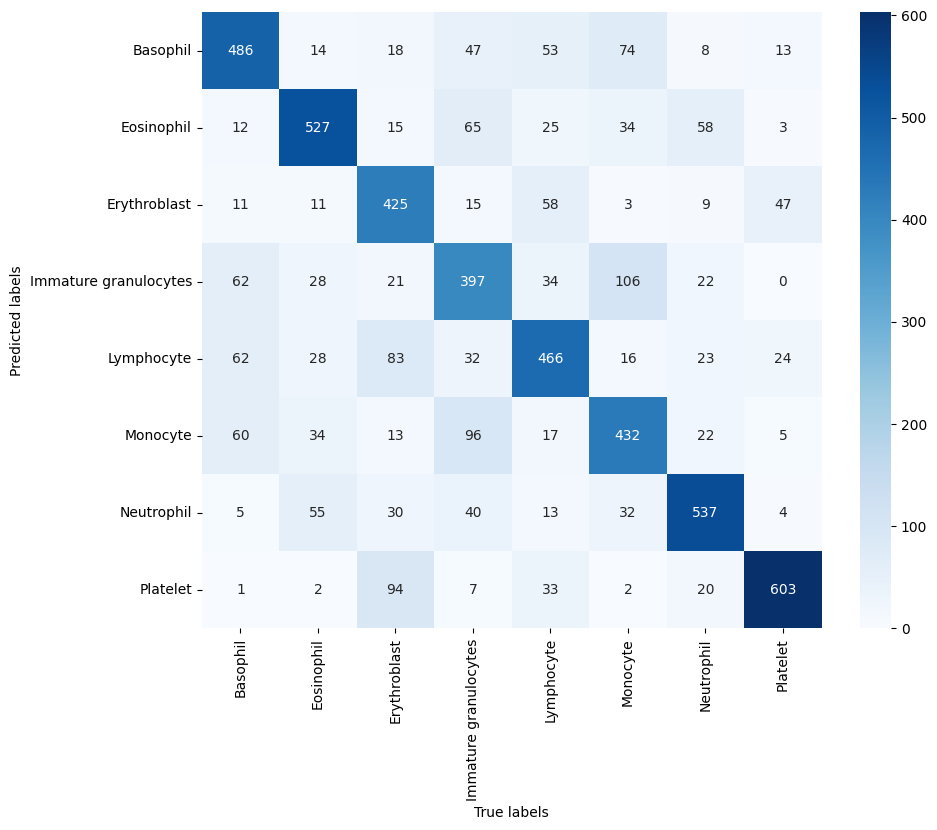

In [13]:
# Load the saved model
tl_model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = tl_model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Calculate and display validation set accuracy
tl_accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the validation set: {round(tl_accuracy, 4)}')

# Calculate and display validation set precision
tl_precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the validation set: {round(tl_precision, 4)}')

# Calculate and display validation set recall
tl_recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the validation set: {round(tl_recall, 4)}')

# Calculate and display validation set F1 score
tl_f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the validation set: {round(tl_f1, 4)}')

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Fine Tuning

In [14]:
# Re-load the best model after transfer learning
ft_model = tfk.models.load_model(model_filename)

In [15]:
# Get the name of the Transfer Learning layer
tl_layer_name = 'densenet121'

# Set the DenseNet model layers as trainable
ft_model.get_layer(tl_layer_name).trainable = True

# Set all DenseNet121 layers as non-trainable
for layer in ft_model.get_layer(tl_layer_name).layers:
    layer.trainable = False

N = 100

# Set the last layers as trainable
for i, layer in enumerate(ft_model.get_layer(tl_layer_name).layers[N:]):
    # Leave BatchNormalization layer frozen, if present
    if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer(tl_layer_name).layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
# ft_model.summary(expand_nested=True)

0 input_layer False
1 zero_padding2d False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block

In [16]:
# Define fine-tuning network hyperparameters
batch_size = 32
epochs = 20
learning_rate = 1e-4

In [17]:
# Lowering the learning rate for fine-tuning
ft_model.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer = tfk.optimizers.AdamW(learning_rate),
    metrics=['accuracy']
)

# Define callbacks for fine-tuning model
# Early stopping callbacks
early_stopping_ft = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = 5,
    restore_best_weights = True
)

# Reduce LR on plateau
reduce_lr_ft = tfk.callbacks.ReduceLROnPlateau (
    monitor = 'val_accuracy',
    mode = 'max',
    factor = 0.1,
    patience = 3
)

callbacks_ft = [early_stopping_ft, reduce_lr_ft]

In [18]:
# Fine-tune the model
ft_history = ft_model.fit (
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks_ft
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'densenet_ft.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 115s 36ms/step - accuracy: 0.7738 - loss: 0.6565 - val_accuracy: 0.9160 - val_loss: 0.2654 - learning_rate: 1.0000e-04
Epoch 2/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.9082 - loss: 0.2887 - val_accuracy: 0.8977 - val_loss: 0.3463 - learning_rate: 1.0000e-04
Epoch 3/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - accuracy: 0.9366 - loss: 0.1966 - val_accuracy: 0.9161 - val_loss: 0.2718 - learning_rate: 1.0000e-04
Epoch 4/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - accuracy: 0.9524 - loss: 0.1500 - val_accuracy: 0.9312 - val_loss: 0.2722 - learning_rate: 1.0000e-04
Epoch 5/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - accuracy: 0.9631 - loss: 0.1164 - val_accuracy: 0.9356 - val_loss: 0.2538 - learning_rate: 1.0000e-04
Epoch 6/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9706 - loss: 0.0924 - val_accuracy: 0.9324 - val_loss: 0.3298 - learning_rate: 1.0000e-04
Epoch 7/20
2039/2039 ━━━━━━━━━━━━━━━━━━

## Evaluate and save the model

175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step
Accuracy score over the validation set: 0.9569
Precision score over the validation set: 0.957
Recall score over the validation set: 0.9569
F1 score over the validation set: 0.9569


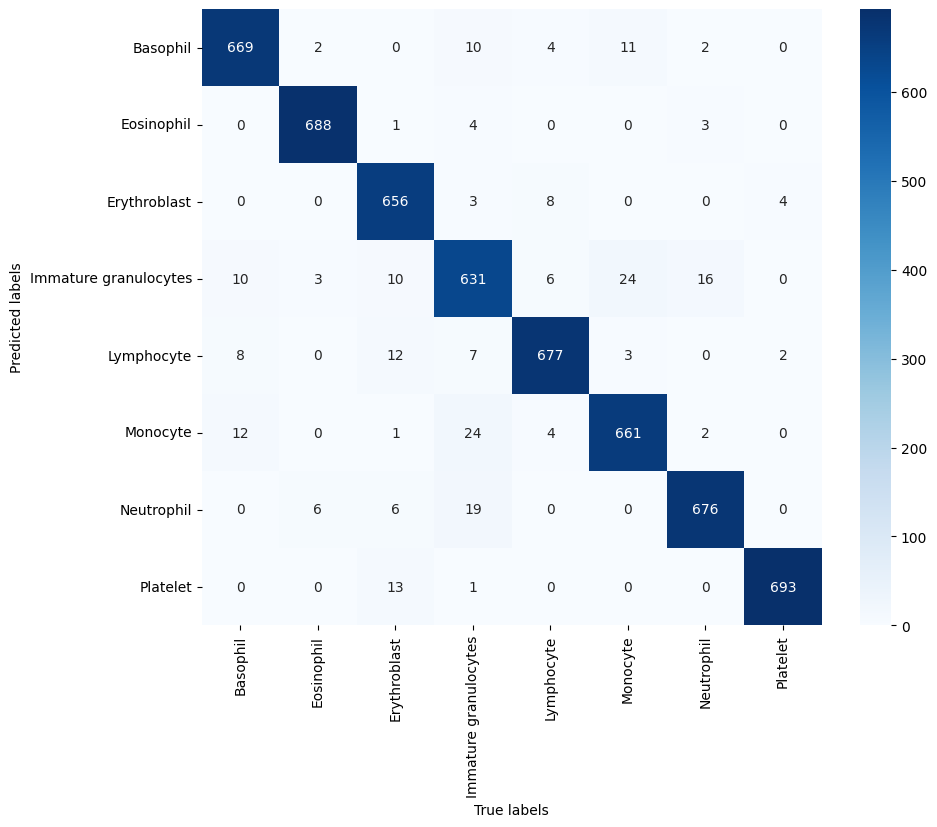

In [19]:
# Load the saved model
ft_model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = ft_model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Calculate and display validation set accuracy
ft_accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the validation set: {round(ft_accuracy, 4)}')

# Calculate and display validation set precision
ft_precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the validation set: {round(ft_precision, 4)}')

# Calculate and display validation set recall
ft_recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the validation set: {round(ft_recall, 4)}')

# Calculate and display validation set F1 score
ft_f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the validation set: {round(ft_f1, 4)}')

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

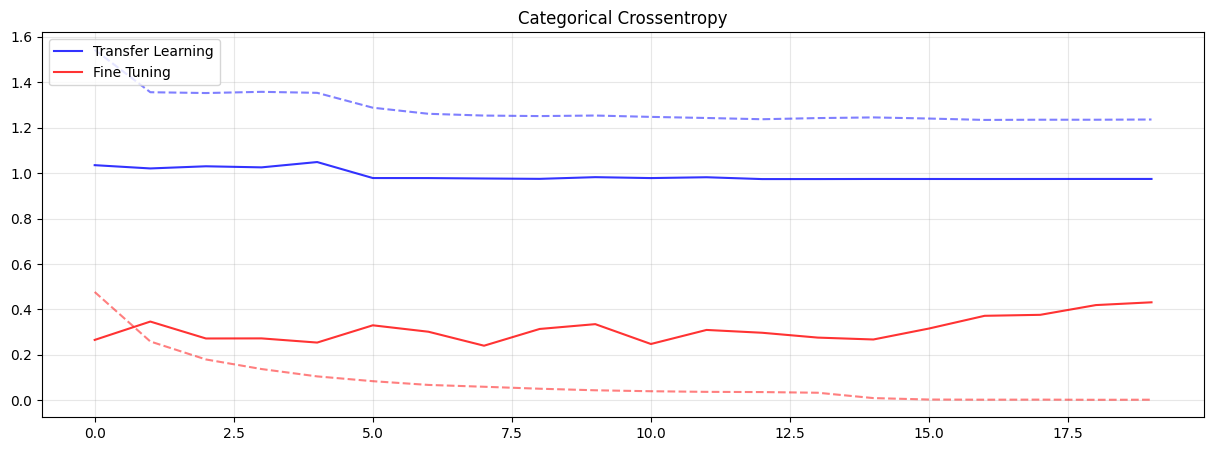

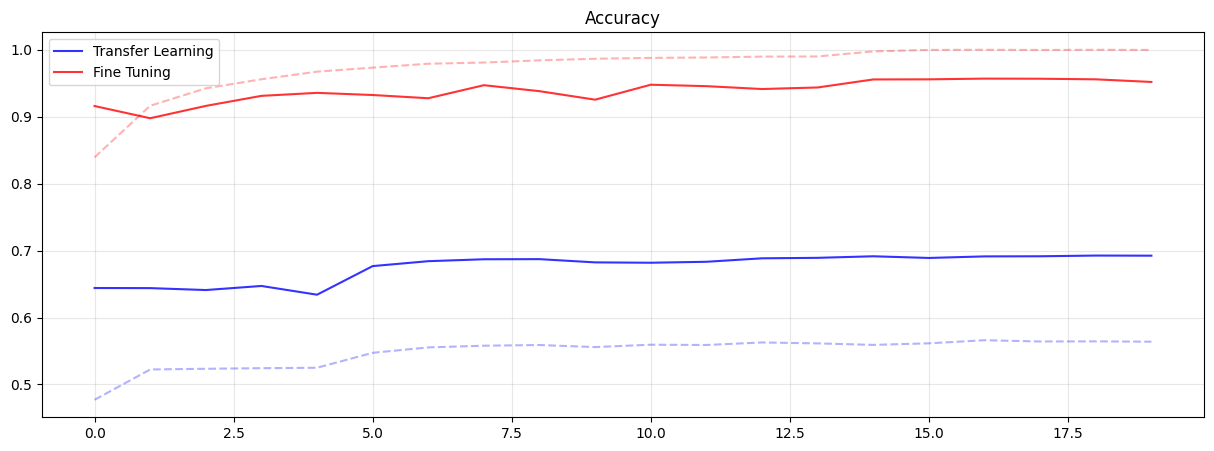

In [20]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15, 5))
plt.plot(tl_history['loss'], alpha=0.5, color='blue', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='blue')
plt.plot(ft_history['loss'], alpha=0.5, color='red', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='red')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=0.3, color='blue', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='blue')
plt.plot(ft_history['accuracy'], alpha=0.3, color='red', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='red')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```


In [21]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
# This flag is set to 'False' by default to manually download the files and create the zip
# otherwise precious resources on Colab are going to be wasted.
download_zip = False

In [ ]:
if download_zip:
  filename = f'convnext_base_ft.zip'

  if IN_COLAB:
    # Add files to the zip command if needed
    !zip {filename} model.py convnext_large_ft.keras

    from google.colab import files
    files.download(filename)

  else:
    # Create the .zip file to be submitted
    import os
    import zipfile

    # Check if model.py and weights.keras exist
    if os.path.exists("model.py") and os.path.exists(model_filename):
        # Create a ZIP file containing model.py and weights.keras
        with zipfile.ZipFile("sub.zip", "w") as model_zip:
            model_zip.write("model.py")
            model_zip.write(model_filename)
        print("model.zip has been created successfully.")
    else:
        print("model.py or weights.keras not found. Please ensure both files are in the current directory.")